In [1]:
from rosemary import jpt_parse_args, jpt_setup, jpt_in_notebook; jpt_setup()

if jpt_in_notebook():
    import os
    os.environ['CUDA_VISIBLE_DEVICES'] = os.environ['CUDA_VISIBLE_DEVICES'].split(',')[0] 
    # '0,1,2,3,4,5'
    print(os.environ['CUDA_VISIBLE_DEVICES'])
    
!nvidia-smi

/gpfs/u/scratch/PTFM/PTFMqngp/github/rosemary/src/rosemary/__init__.py:25: UserWarning: Install `torch` for functionalities dependent on torch
  warn(f'Install `torch` for functionalities dependent on torch')


0
Wed Nov  1 23:25:19 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000004:04:00.0 Off |                    0 |
| N/A   29C    P0    38W / 300W |      0MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000035:05:00.0 Off |                    0 |
| N/A 

In [5]:
import os
import itertools
from rosemary import jpt_in_notebook
from llm.submit import submit_job, multiline_to_singleline, shell_scripts_template_slurm

log_dir = '/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/'

test_run = 1
test_run = bool(test_run)

# model_name = 'llama-7b'
model_name = 'llama-7b+lora:r=256:a=256' # includes lora grad norm
# model_name = 'llama-7b_ft=hmv1' # means llama-7b finetuned on tulu humanmix already.
model_name = 'mistral-7b+lora:r=256:a=256'


sort_by_list = [
    'random_s=0', 'random_s=1', 'random_s=2',
#     'log_prob', 'logit_margin', 'el2n_agg=mean',
#     'grad_loraB_l2n',
]
# sort_by_list += [
# #     'kmeansl2_emb=grad+rp+loraB_nc=300',
#     'kmeansl2_emb=grad+rp+loraB_nc=1000',
#     'kmeansl2_emb=grad+rp+loraB_nc=3000',
# #     'kmeansl2_emb=text+embedding_nc=300',
#     'kmeansl2_emb=text+embedding_nc=1000',
#     'kmeansl2_emb=text+embedding_nc=3000',
# ]
# sort_by_list += [
#     'dppmap_emb=grad+rp+loraB_k=Kcos', 
#     'dppmap_emb=text+embedding_k=Kcos', 
#     'dppmap_emb=grad+rp+loraB_k=Kcosp', 
#     'dppmap_emb=text+embedding_k=Kcosp',
#     'dppmap_emb=grad+rp+loraB_k=Kcos1np', 
#     'dppmap_emb=text+embedding_k=Kcos1np',
# ]
# dataset_list = ['lima']
# dataset_list = ['flan2022_1m']
# dataset_list = ['tulu_v1_mix']
dataset_list = ['ultrachat']

# sort_by_list = [
#  'log_prob',
#  'el2n_agg=mean',
#  'el2n_agg=l2n',
#  'logit_margin',
# ]
# if 'lora' in model_name:
#     sort_by_list += ['grad_loraB_l2n']
# else:
#     sort_by_list += ['grad_all_l2n', 'grad_qkv_l2n', 'grad_mlp_l2n', 'grad_last_l2n',]
# sort_by_list = ['kmeansl2_emb=grad+rp+loraB_nc=30',
#                 'kmeansl2_emb=text+embedding_nc=30']
# dataset_list = ['lima']


# model_name = 'pythia-1b-deduped'
# model_name = 'pythia-1b-deduped+lora:r=256:a=256'
# dataset_list = ['cot', 'dolly', 'flan_v2', 'lima', 'oasst1']
# # sort_by_list = ['random_s=0', 
# #                 'log_prob', 'logit_margin', 'el2n_agg=mean', 'el2n_agg=l2n', 
# #                 'kmeansl2_nc=3000', 'kmeanscd_nc=3000',
# #                 'grad_loraB_l2n',
# #                 'grad_all_l2n', 'grad_qkv_l2n', 'grad_mlp_l2n', 'grad_last_l2n',
# #                ]
# sort_by_list = ['grad_loraB_l2n']

from note_pruning_analysis import lm_output_dir, data_inds_dir
save_dir = os.path.join(data_inds_dir, model_name)
lm_output_dir = os.path.join(lm_output_dir, model_name)

options_list = itertools.product(dataset_list, sort_by_list)

print('test_run =',test_run)
cmds = []
for dataset, sort_by in options_list:
    cmd = f"""
     python note_pruning.py \
        --dataset {dataset} \
        --sort_by {sort_by} \
        --lm_output_dir {lm_output_dir} \
        --save_dir {save_dir} \
    """.strip()
    cmd = multiline_to_singleline(cmd)
    shell_scripts = shell_scripts_template_slurm.format(
        conda_env='open-instruct',
        cwd=os.getcwd(),
        cmd=cmd,
        log_dir=log_dir,
        save_dir=os.path.join(save_dir, dataset))
    out = submit_job(
        shell_scripts, 
        job_name=f'prune.{dataset}.{sort_by}', 
        nodes=1,
        num_cpus=64, # 32
        cpu_mem=256, # 128
        num_gpus=1,
        gpu_type='v100',
        test_run=test_run,
        job_duration=6,
    )
    cmds.append(cmd)
    print(cmd)
        
print('#cmds: ', len(cmds))


test_run = True

Submiting job with:
{
    "job_name": "prune.ultrachat.random_s=0",
    "nodes": 1,
    "num_cpus": 64,
    "cpu_mem": 256,
    "num_gpus": 1,
    "gpu_type": "v100",
    "test_run": true,
    "queue": "el8",
    "num_jobs": 1
}
python note_pruning.py --dataset ultrachat --sort_by random_s=0 --lm_output_dir /gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/model_outputs/mistral-7b+lora:r=256:a=256 --save_dir /gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/data_inds/mistral-7b+lora:r=256:a=256

Submiting job with:
{
    "job_name": "prune.ultrachat.random_s=1",
    "nodes": 1,
    "num_cpus": 64,
    "cpu_mem": 256,
    "num_gpus": 1,
    "gpu_type": "v100",
    "test_run": true,
    "queue": "el8",
    "num_jobs": 1
}
python note_pruning.py --dataset ultrachat --sort_by random_s=1 --lm_output_dir /gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/model_outputs/mistral

### Generate curriculum from pre-computed scores (via `note_pruning.py`)

In [43]:
import itertools
from note_curriculum import (
    get_curriculum_scores,
    get_curriculum,
    generate_curriculum,
    generate_curriculum_forall_scoring_fn,
    scores_path_to_attrs,
    np_random_choice_maximize_noreplacement,
)

# model_name = 'llama-7b'; dataset = 'tulu_v1_mix'; M = 150_000
# # model_name = 'mistral-7b'; dataset = 'ultrachat'; M =  50_000

# pacing_fn_list = [
#     f'prune_size={M}_ep=1',
#     f'prune_size={M}_ep=3',
#     f'singlestep_size={M}_startingfrac=0.2',
#     f'singlestep_size={M}_startingfrac=0.1',
# ]

# output_list = generate_curriculum_forall_scoring_fn(
#     model_name, dataset, pacing_fn_list, verbose=False)

In [85]:
import pickle
output = get_curriculum('llama-7b+lora:r=256:a=256',
               'tulu_v1_mix',
               'log_prob_neg',
               'prune_size=150000_ep=3')
inds_n = np.unique(output['inds'])

p = '/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/data_inds/llama-7b+lora:r=256:a=256/tulu_v1_mix/log_prob_decr.pkl'
with open(p, 'rb') as f:
    inds_p = np.array(pickle.load(f)['inds'])[:50_000]
    
    
# np.unique(inds_n).shape, inds_p.shape

np.sort(inds_n), np.sort(inds_p)
# len(set(list(inds_n)) & set(list(inds_p)))


(array([     4,     12,     34, ..., 482120, 482139, 482143]),
 array([     4,     12,     34, ..., 482120, 482139, 482143]))

In [80]:
+ srun torchrun --nnodes=5 --nproc_per_node=6 --rdzv-id=1133923 --rdzv-backend=c10d --rdzv-endpoint=dcs093:10002 open_instruct/finetune_trainer.py --model_name_or_path=results/baselines/huggyllama/llama-7b --tokenizer_name=results/baselines/huggyllama/llama-7b --use_fast_tokenizer=True --train_file=data/processed/tulu/tulu_v1_mix.jsonl --max_seq_length=2048 --do_train --preprocessing_num_workers=16 --per_device_train_batch_size=2 --gradient_accumulation_steps=2 --learning_rate=2e-5 --lr_scheduler_type=linear --warmup_ratio=0.03 --weight_decay=0. --optim=adamw_hf --evaluation_strategy=no --logging_steps=1 --save_strategy=steps --save_steps=100 --save_total_limit=1 --num_train_epochs=1 '--fsdp=full_shard auto_wrap' --fsdp_transformer_layer_cls_to_wrap=LlamaDecoderLayer --gradient_checkpointing --report_to=tensorboard --torch_dtype=float32 --dataloader_num_workers=8 --fp16=True --subsample_inds_file=/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/log_prob_neg/inds_prune_size=150000_ep=3.pkl --dataloader_sampler SequentialSampler --output_dir=results/oi5_tulu_v1_mix:llama-7b/llama-7b_tuluv1m_score=log:prob:neg_pace=prune:size=150000:ep=3
+ srun torchrun --nnodes=5 --nproc_per_node=6 --rdzv-id=1082124 --rdzv-backend=c10d --rdzv-endpoint=dcs199:10002 open_instruct/finetune_trainer.py --model_name_or_path=results/baselines/huggyllama/llama-7b --tokenizer_name=results/baselines/huggyllama/llama-7b --use_fast_tokenizer=True --train_file=data/processed/tulu/tulu_v1_mix.jsonl --max_seq_length=2048 --max_train_samples=50000 --do_train --preprocessing_num_workers=16 --per_device_train_batch_size=2 --gradient_accumulation_steps=2 --learning_rate=2e-5 --lr_scheduler_type=linear --warmup_ratio=0.03 --weight_decay=0. --optim=adamw_hf --evaluation_strategy=no --logging_steps=1 --save_strategy=steps --save_steps=100 --save_total_limit=1 --num_train_epochs=3 '--fsdp=full_shard auto_wrap' --fsdp_transformer_layer_cls_to_wrap=LlamaDecoderLayer --gradient_checkpointing --report_to=tensorboard --torch_dtype=float32 --dataloader_num_workers=8 --fp16=True --subsample_inds_file=/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/data_inds/llama-7b+lora:r=256:a=256/tulu_v1_mix/log_prob_decr.pkl --output_dir=results/oi4_tulu_v1_mix_ep=3/llama-7b_tuluv1m:50k_log_prob_decr


11.268095016479492

In [65]:
import re
import numpy as np
from note_curriculum import get_curriculum_scores
import glob

paths = glob.glob('curriculum/*/*/*/scores.pkl')
paths = [x for x in paths if 'llama' in x and 'tulu_v1_mix' in x and 'log_prob_neg' in x]
path = paths[0]

verbose = False
print(path)
M = 150_000
pacing_fn = f'prune_size={M}_ep=3'
pacing_fn = f'singlestep_size={M}_startingfrac=0.1'
pacing_fn = f'fep_size={M}_nsteps=2_startingfrac=0.1_inc=0.1'


output = get_curriculum_scores(path)
output['pacing_fn'] = pacing_fn

scores = output['scores']
N = scores.size
inds_sorted = np.argsort(scores).tolist() # increasing `scores`.
match = re.search(r'_s=([^_]+)', pacing_fn)
seed = int(match.group(1)) if match else 0

np.random.seed(seed)

inds_sorted = np.arange(len(inds_sorted))/len(inds_sorted)

if pacing_fn.startswith('prune'):

    match = re.search(r'size=([^_]+)', pacing_fn)
    M = int(match.group(1)) # total data points over `num_epochs` epochs.
    match = re.search(r'ep=([^_]+)', pacing_fn)
    num_epochs = int(match.group(1))

    if M >= len(inds_sorted):
        raise ValueError(f'size={M} > len(inds)={len(inds_sorted)}')

    sizes = []
    for _ in range(num_epochs-1):
        sizes.append(int(M//num_epochs))
    sizes.append(int(M-np.sum(sizes)))

    inds = []
    for size in sizes:
        inds_kept = list(inds_sorted[:size])
        np.random.shuffle(inds_kept)
        inds.append(inds_kept)
    inds = [x for sl in inds for x in sl]
    inds = np.array(inds)

    if len(inds) != M:
        raise ValueError('len(inds) should be equal to size')
elif pacing_fn.startswith('singlestep'):

    match = re.search(r'size=([^_]+)', pacing_fn)
    M = int(match.group(1))
    match = re.search(r'startingfrac=([\d.]+)', pacing_fn)
    startingfrac = float(match.group(1))

    inds_step1 = list(inds_sorted[:int(startingfrac*N)])
    inds_step1_size = int(M//2)
    if verbose:
        print(f'Step 1: sample {inds_step1_size} from first {len(inds_step1)} examples.')
    inds_step1 = np_random_choice_maximize_noreplacement(inds_step1, inds_step1_size)

    inds_step2 = list(inds_sorted)
    inds_step2_size = M-inds_step1_size
    if verbose:
        print(f'Step 2: sample {inds_step2_size} from the rest of {len(inds_step2)} examples.')
    inds_step2 = np_random_choice_maximize_noreplacement(inds_step2, inds_step2_size)

    inds = [inds_step1, inds_step2]
    inds = np.hstack([x.reshape(-1) for x in inds])

    if len(inds) != M:
        raise ValueError('len(inds) should be equal to size')
elif pacing_fn.startswith('fep'):
#     pacing_fn = f'fep_size={M}_nsteps=2_startingfrac=0.1_inc=0.1'
    
    match = re.search(r'size=([^_]+)', pacing_fn)
    M = int(match.group(1))
    match = re.search(r'startingfrac=([\d.]+)', pacing_fn)
    startingfrac = float(match.group(1))
    match = re.search(r'nsteps=([^_]+)', pacing_fn)
    nsteps = int(match.group(1))
    match = re.search(r'inc=([\d.]+)', pacing_fn)
    inc = float(match.group(1))
    


else:
    raise ValueError(f'{pacing_fn} not implemented.')

    
    
    
print(M, startingfrac, nsteps, inc)


step_lens = []
for _ in range(nsteps-1):
    step_lens.append(int(M//nsteps))
step_lens.append(int(M-np.sum(step_lens)))






curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/log_prob_neg/scores.pkl
150000 0.1 2 0.1


[75000, 75000]

Text(0.5, 1.0, '')

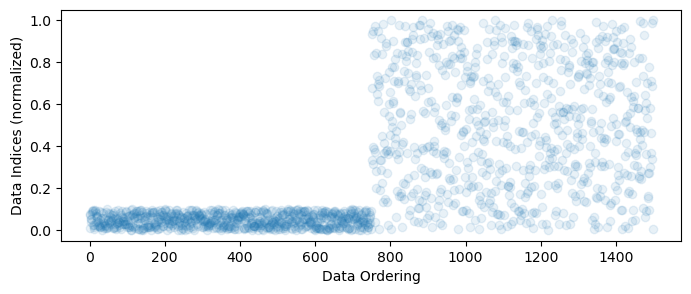

In [61]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1,figsize=(8,3))

ys = inds[::100]
# ys = scores[inds[::100]]
ax.scatter(np.arange(len(ys)), ys, alpha=.1)
# ax.set_ylim((0,1))
ax.set_ylabel('Data Indices (normalized)')
ax.set_xlabel('Data Ordering')
ax.set_title('')


### main code

In [7]:
import os
import sys
import numpy as np
import time
import re
import random
import pickle
from tqdm import tqdm 

import pyarrow
import torch
import transformers
import pandas as pd

from note_pruning import (
    save_to_pickle,
    save_sorted_inds,
    sort_kmeans_dist_to_cluster_centers,
    sort_dpp_map,)

In [8]:
test_run = False
dataset = 'tulu_v1_human_mix'
dataset = 'tulu_v2_human_mix'
dataset = 'flan_v2'
dataset = 'lima'
dataset = 'flan2022_1m'
dataset = 'tulu_v1_mix'

# sort_by = 'random_s=0'
# sort_by = 'kmeansl2_nc=3000'
# sort_by = 'kmeanscd_nc=3000'
sort_by = 'log_prob'
# sort_by = 'dppmap_k=Kcos'
# sort_by = 'dppmap_k=Kcos1np'
# sort_by = 'el2n'
# sort_by = 'grad_norm'
# sort_by = 'kmeansl2_emb=grad+rp+loraB_nc=3000'
# sort_by = 'kmeansl2_emb=text+embedding_nc=3000'
# sort_by = 'dppmap_emb=text+embedding_k=Kcos'


# used for generating model output.
# model_name = 'llama-7b'
# model_name = 'llama-7b_ft=hmv1'
model_name = 'llama-7b+lora:r=256:a=256'


save_dir = f"/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/data_inds/{model_name}/"
lm_output_dir = f'/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/model_outputs/{model_name}'
save_dir = os.path.join(save_dir, dataset)
os.makedirs(save_dir, exist_ok=True)

In [29]:
save_path = os.path.join(lm_output_dir, f'{dataset}.pkl')
with open(save_path, 'rb') as f:
    d = pickle.load(f)
if test_run:
    d = {k: v[:10000] for k, v in d.items()}

# some entries are nan, impute with mean value.
N = d['text_embedding'].shape[0]
log_prob = np.nan_to_num(d['log_prob'], nan=np.nanmean(d['log_prob'])).squeeze()
print(N)

482145


In [30]:
## the copy in `note_pruning.py` is most up to date
from note_pruning import sort_dpp_map_memefficient

pkl_extra = {}

t0 = time.time()
if any(sort_by.startswith(x) for x in [
        'log_prob', 
        'el2n',  # el2n_agg={l2n|mean}
        'logit_margin', 
        'grad',  # grad_{loraB|qkv|all|last}_l2n
    ]):
    if sort_by not in d:
        print(f'sort_by={sort_by} not in lm_output_dir={lm_output_dir}')
    S = np.nan_to_num(d[sort_by], nan=np.nanmean(d[sort_by])).squeeze()
elif sort_by.startswith('random'):
    match = re.search(r's=(\d+)', sort_by)
    seed = int(match.group(1))
    np.random.seed(seed)
    S = np.random.rand(N)
    assert(S.shape == np.unique(S).shape)
if sort_by.startswith('kmeans'):
    dist_fn = 'l2' if sort_by.startswith('kmeansl2') else 'cd'
    match = re.search(r'nc=(\d+)', sort_by)
    n_clusters = int(match.group(1)) if match else None
    match = re.search(r'emb=([^_]+)', sort_by)
    embed_type = re.sub(r'[+]', '_', match.group(1)) if match else 'text_embedding'
    if embed_type not in set(d.keys()).intersection(set(['text_embedding', 'grad_rp_loraB'])):
        raise ValueError(f'Invalid embed_type = {embed_type}')
    emb = d[embed_type]
    print(f'Running kmeans(n_clusters={n_clusters}) {{ {embed_type} }} to compute {"euclidean" if dist_fn == "l2" else "cosine"} distance to cluster centers.')
    S, kms = sort_kmeans_dist_to_cluster_centers(emb, n_clusters, dist_fn=dist_fn)
    pkl_extra['kmeans'] = kms
elif sort_by.startswith('dpp'):
    match = re.search(r'k=(\w+)', sort_by)
    kernel_type = match.group(1) if match else None
    match = re.search(r'emb=([^_]+)', sort_by)
    embed_type = re.sub(r'[+]', '_', match.group(1)) if match else 'text_embedding'
    if embed_type not in set(d.keys()).intersection(set(['text_embedding', 'grad_rp_loraB'])):
        raise ValueError(f'Invalid embed_type = {embed_type}')
    emb = d[embed_type]
    inds = sort_dpp_map_memefficient(emb, log_prob, kernel_type=kernel_type, torch_compile=False)
t1 = time.time()
print(f'Rank datapoints with {sort_by} took {t1-t0:.2f} seconds.')

# if any(sort_by.startswith(x) for x in ['dpp']):
#     output = {'inds': inds}
#     if pkl_extra:
#         output.update(pkl_extra)
#     save_to_pickle(
#         save_path=os.path.join(save_dir, f'{sort_by}.pkl'),
#         output=output)
# else:
#     save_sorted_inds(save_dir, S, sort_by, extra=pkl_extra, reverse=False)
#     save_sorted_inds(save_dir, S, sort_by, extra=pkl_extra, reverse=True)

#     ## use `note_pruning` to generate scores for curriculum learning.
#     model_name = os.path.basename(lm_output_dir)
#     for pacing_fn in [sort_by, sort_by+'_neg']:
#         curriculum_output_dir = os.path.join('curriculum', model_name, dataset, pacing_fn)
#         os.makedirs(curriculum_output_dir, exist_ok=True)
#         save_path = os.path.join(curriculum_output_dir, 'scores.pkl')
#         output = {'S': -S if pacing_fn.endswith('_neg') else S}
#         save_to_pickle(save_path=save_path, output=output)

Rank datapoints with log_prob took 0.00 seconds.
